In [1]:
import numpy as np

In [2]:
from scipy.stats import chi2

In [3]:
import matplotlib.pyplot as plt

In [39]:
import seaborn as sns

In [40]:
def model(xi,biasIndex):
    #if biasIndex = 0, we assume no bias
    #if biasIndex not 0, its value is where bias is injected
    if biasIndex == 0:
        m = xi.shape[1]
        H = np.concatenate((xi,np.ones((1,m)))).T
        return H
    else:
        m = xi.shape[1]
        H = np.concatenate((xi,np.ones((1,m)),np.zeros((1,m)))).T
        H[biasIndex-1,2] = 1.
        return H

In [41]:
def measurement(H,X,R,bias):
    #generates measurements and adds a bias
    (m,n) = H.shape
    Y = H@X+np.linalg.cholesky(R)@np.random.randn(m,1) + bias
    return Y

In [42]:
def projector(H,R):
    #returns (I-Htilde*Stilde)
    L = np.linalg.cholesky(R)
    (m,n) = H.shape
    Htilde = np.linalg.solve(L,np.eye(m))@H
    Stilde = np.linalg.solve((Htilde.T@Htilde),np.eye(n))@(Htilde.T)
    P = np.eye(m)-Htilde@Stilde
    return P

In [43]:
def residus(Y,P,R):
    #Y : measurements
    #P : projector
    #R : noise covariance matrix
    L = np.linalg.cholesky(R)
    (m,m) = P.shape
    Ytilde = np.linalg.solve(L,np.eye(m))@Y
    res = (Ytilde.T@P@Ytilde)
    return res

In [44]:
def modelEstimationAndLikelihood(xi,Y,biasIndex,R):
    H = model(xi,biasIndex)
    L = np.linalg.cholesky(R)
    (m,n) = H.shape
    Htilde = np.linalg.solve(L,np.eye(m))@H
    Stilde = np.linalg.solve((Htilde.T@Htilde),np.eye(n))@(Htilde.T)
    Ytilde = np.linalg.solve(L,np.eye(m))@Y
    Xestim = Stilde@Ytilde
    dof = m-n
    P = projector(H,R)
    res = residus(Y,P,R)
    likelihood = chi2.pdf(res,dof)
    return(likelihood,res,Xestim)

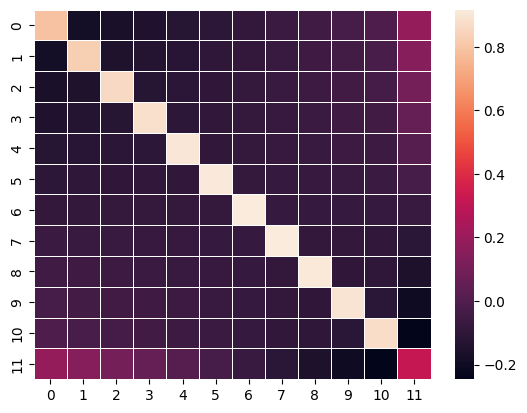

min entry : 0.3188405797101451 index 11
max entry : 0.9164690382081687 index 6


In [161]:
N = 12 #number of points
#xi = np.arange(N).reshape((1,N)) #x values
xi = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,10.]).reshape((1,N))

#Ground truth
Xtrue = np.array([[1.],[2.]])
Htrue = model(xi,0)
R = ((2e-2)**2)*np.eye(N) #noise covariance matrix
bias = np.zeros((N,1))
bias[11,0] = -0.19 #bias introduction, python indexes at 0 !!
Y = measurement(Htrue,Xtrue,R,bias) #measurements
sns.heatmap(projector(Htrue,R), linewidth=0.5)
plt.show()
Ptrue = projector(Htrue,R)
diagtrue = np.diag(Ptrue)
imin = np.argmin(diagtrue)
imax = np.argmax(diagtrue)
pmin = np.min(diagtrue)
pmax = np.max(diagtrue)
print("min entry : {} index {}".format(pmin,imin))
print("max entry : {} index {}".format(pmax,imax))

In [162]:
likelihood = []
res = []
estim = []
for i in range(N+1):
    (likelihood_i,res_i,estim_i) = modelEstimationAndLikelihood(xi,Y,i,R)
    likelihood.append(likelihood_i)
    res.append(res_i)
    estim.append(estim_i)

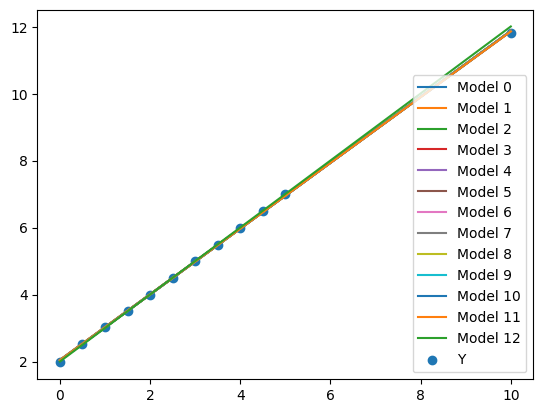

In [163]:
for i in range(N+1):
    x1 = xi[0,0]
    x2 = xi[0,-1]
    xest = estim[i]
    y1 = xest[0]*x1+xest[1]
    y2 = xest[0]*x2+xest[1]
    plt.plot([x1,x2],[y1,y2],label="Model {}".format(i))
plt.scatter(xi,Y,label="Y")
plt.legend()
plt.show()

Text(0, 0.5, 'Likelihood')

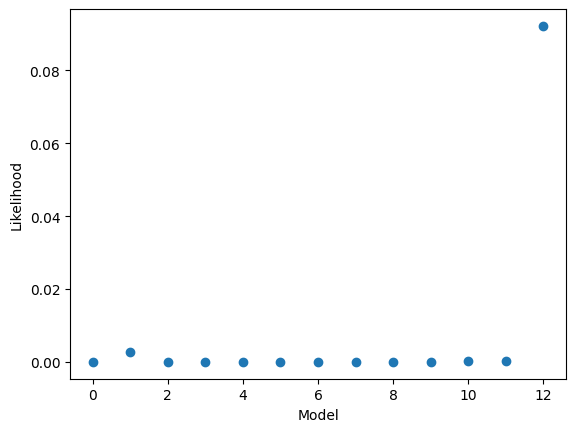

In [164]:
likelihood = np.array(likelihood).reshape(N+1)
plt.scatter(np.arange(N+1),likelihood)
plt.xlabel("Model")
plt.ylabel("Likelihood")

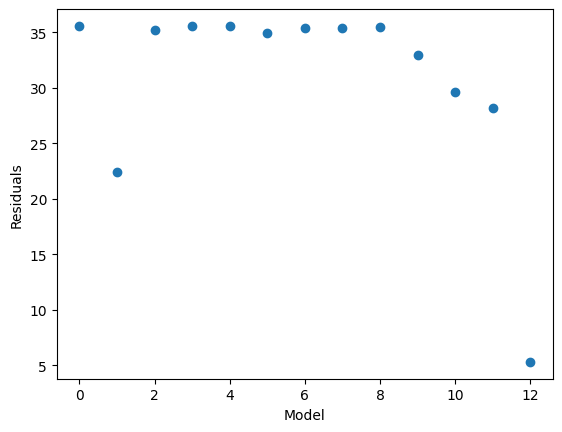

In [165]:
res = np.array(res).reshape(N+1)
plt.scatter(np.arange(N+1),res)
plt.xlabel("Model")
plt.ylabel("Residuals")
plt.show()